# Clustering Online Retail Dataset using Kmeans

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

sns.set(style="whitegrid", palette="Set2", context="talk")

# Load Data

In [2]:
df = pd.read_excel('/kaggle/input/online-retail-dataset/online_retail_II.xlsx')

print("Shape", df.shape)
df.head()

Shape (525461, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# EDA & Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [4]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


In [5]:
df = df.dropna(subset=['Customer ID'])
df.shape

(417534, 8)

> I saw negative quantities and prices so there might be returns, refunds, or order cancellations. So, letes check Invoice

In [6]:
df[df['Invoice'].astype(str).str.startswith('C')]


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


> Indeed there are Invoices starting with C for it
> Now lets remove those because if included, it'll subtract revenue that was never earned. which inturn casuses Monetary feature incorrect, misleading Recency, Distorted frequency

In [7]:
df = df[~df['Invoice'].astype(str).str.startswith('C')]

In [8]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,407695.000000,407695,407695.000000,407695.000000
mean,13.586686,2010-07-01 10:10:10.782178048,3.294188,15368.504107
min,1.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,2.000000,2010-03-26 14:01:00,1.250000,13997.000000
50%,5.000000,2010-07-09 15:46:00,1.950000,15321.000000
75%,12.000000,2010-10-14 17:09:00,3.750000,16812.000000
max,19152.000000,2010-12-09 20:01:00,10953.500000,18287.000000
std,96.842229,NaN,34.756655,1679.795700


> So Negative prices and quantity is removed too

In [9]:
df = df.copy()

df['Customer ID'] = df['Customer ID'].astype(int)
df['Total'] = df['Quantity'] * df['Price']
print("After cleaning:", df.shape)

After cleaning: (407695, 9)


# Compute RFM Features

In [10]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

> Reference date (1 day after last transaction)


In [11]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  
    'Invoice': 'nunique',                                     
    'Total': 'sum'                                           
}).reset_index()

rfm.rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'Total': 'Monetary'}, inplace=True)

rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346,165,11,372.86
1,12347,3,2,1323.32
2,12348,74,1,222.16
3,12349,43,3,2671.14
4,12351,11,1,300.93


> Computed RFM per customer

# Data Preprocessing

In [12]:
rfm[['Recency', 'Frequency', 'Monetary']].describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4314.0,91.269124,96.943482,1.0,18.00,53.00,136.0000,374.00
Frequency,4314.0,4.454103,8.168658,1.0,1.00,2.00,5.0000,205.00
Monetary,4314.0,2047.288659,8912.523243,0.0,307.95,705.55,1722.8025,349164.35


## Log-Transform

In [13]:
rfm_log = rfm.copy()
rfm_log[['Recency', 'Frequency', 'Monetary']] = rfm_log[['Recency', 'Frequency', 'Monetary']].apply(lambda x: np.log1p(x))

## Scale features

In [14]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])

#  K-Means Clustering

##  Elbow Method to find optimal k

In [15]:
inertia = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',   
        n_init=10, 
        random_state=42
    )
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

> Used kmeans++ for better centroid initialization

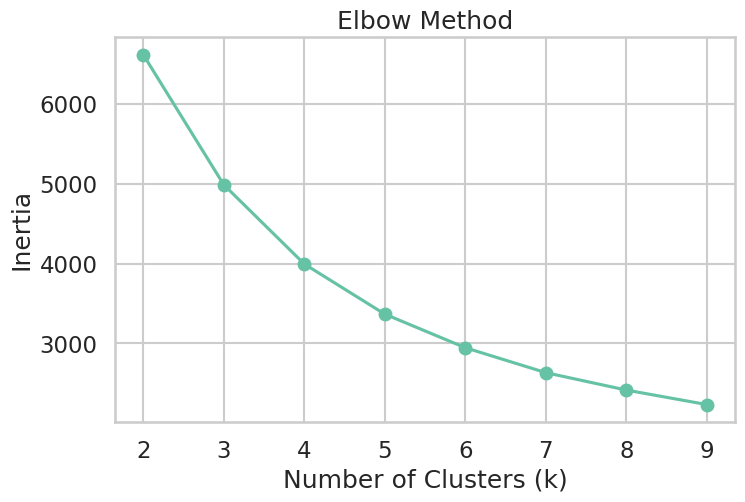

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'o-')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

> K = 4 seems optimal seeing graph elbow like structure in point 4

#  Fit Final Model (final k)

In [17]:
k = 4 
kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,  random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()

,Customer ID,Recency,Frequency,Monetary,Cluster
0,12346,165,11,372.86,2
1,12347,3,2,1323.32,3
2,12348,74,1,222.16,1
3,12349,43,3,2671.14,2
4,12351,11,1,300.93,3


#  Evaluate Clustering

In [18]:
sil_score = silhouette_score(rfm_scaled, rfm['Cluster'])
db_index = davies_bouldin_score(rfm_scaled, rfm['Cluster'])

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies–Bouldin Index: {db_index:.3f}")

Silhouette Score: 0.332
Davies–Bouldin Index: 1.009


# Cluster Analysis

In [19]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Customer ID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
}).rename(columns={'Customer ID': 'Num_Customers'}).reset_index()

cluster_summary

,Cluster,Num_Customers,Recency,Frequency,Monetary
0,0,779,13.892169,13.549422,7400.407019
1,1,1403,187.090520,1.287954,300.726751
2,2,1185,83.366245,4.128270,1774.780264
3,3,947,22.846885,2.070750,572.388554


#  Visualization

## Bar plot: cluster sizes


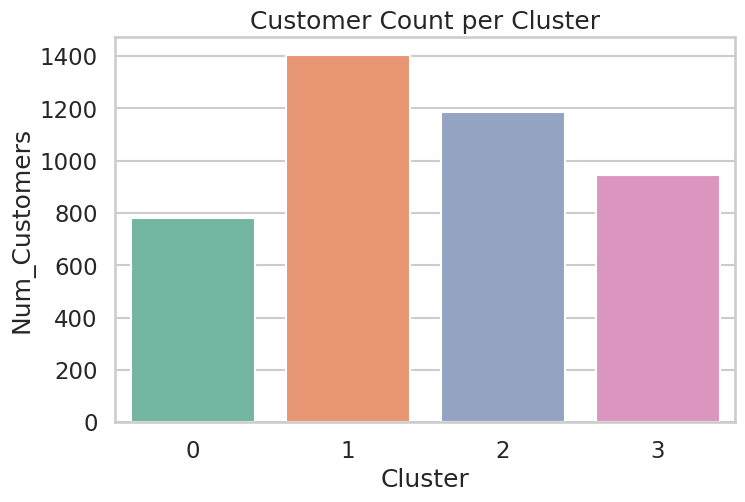

In [20]:
plt.figure(figsize=(8,5))
sns.barplot(x='Cluster', y='Num_Customers', data=cluster_summary, palette='Set2')
plt.title("Customer Count per Cluster")
plt.show()

## Heatmap of cluster feature means

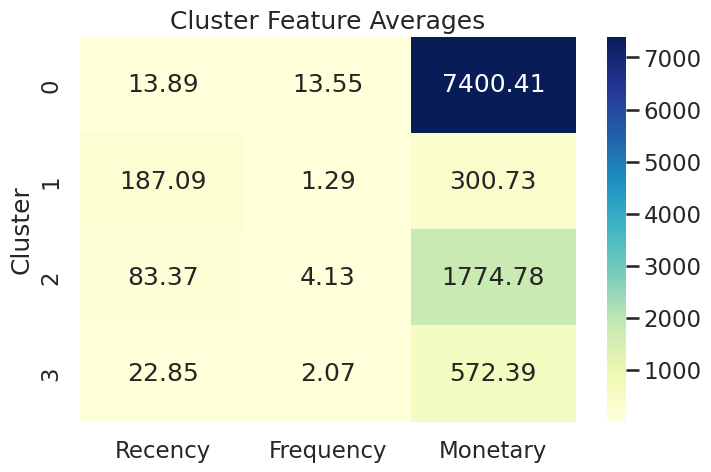

In [21]:
plt.figure(figsize=(8,5))
sns.heatmap(cluster_summary.set_index('Cluster').drop('Num_Customers', axis=1), annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("Cluster Feature Averages")
plt.show()

## 2D scatter plot ( Recency vs Monetary)


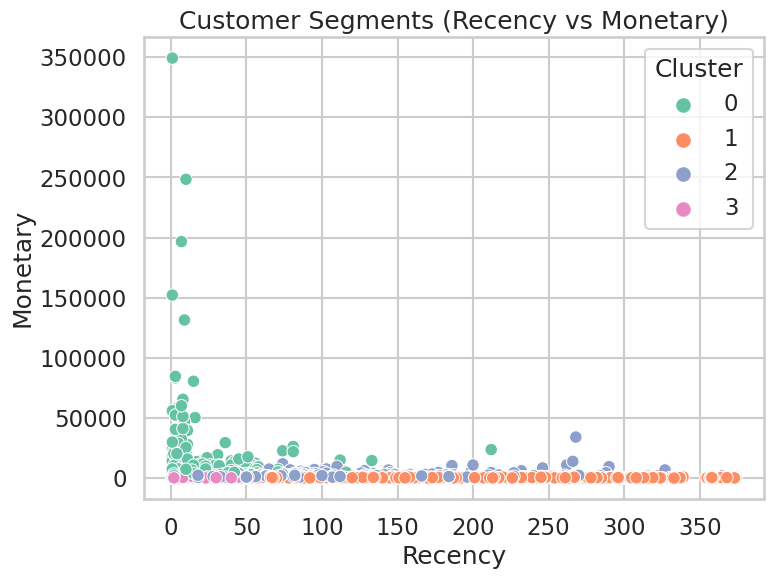

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='Set2')
plt.title("Customer Segments (Recency vs Monetary)")
plt.show()

## Pie Chart — Cluster Sizes

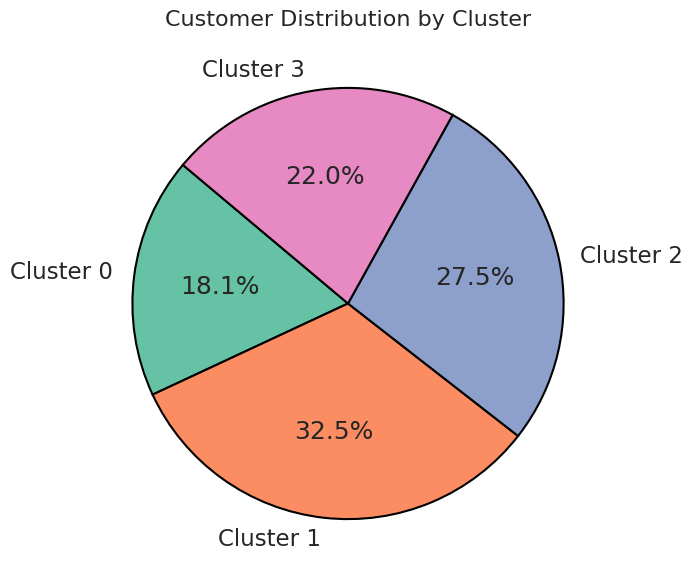

In [23]:
plt.figure(figsize=(7,7))
plt.pie(
    cluster_summary['Num_Customers'],
    labels=[f"Cluster {i}" for i in cluster_summary['Cluster']],
    autopct='%1.1f%%',
    colors=sns.color_palette("Set2", len(cluster_summary)),
    startangle=140,
    wedgeprops={'edgecolor':'black'}
)
plt.title("Customer Distribution by Cluster", fontsize=16)
plt.show()